# Image colorization

In [5]:
import os
from pathlib import Path
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

import PIL
from PIL import Image
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.models.resnet import resnet18
from torchvision.models.vgg import vgg19
from torch.utils.data import Dataset, DataLoader

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

COCO dataset ucitavanje.

In [27]:
from fastai.vision.learner import create_body
from fastai.vision.models.unet import DynamicUnet
from fastai.data.external import untar_data, URLs

path = untar_data(URLs.COCO_SAMPLE)
path = str(path) + "/train_sample"
paths = glob.glob(path + "/*.jpg")

Odabir 10000 slika iz COCO dataset-a.

In [32]:
np.random.seed(42)
paths_subset = np.random.choice(paths, 10000, replace=False)
perm = np.random.permutation(10000) 
train_idx, val_idx = perm[:8000], perm[2000:]
train_paths, val_paths = paths_subset[train_idx], paths_subset[val_idx]

Prikaz 16 slika iz COCO dataset-a.

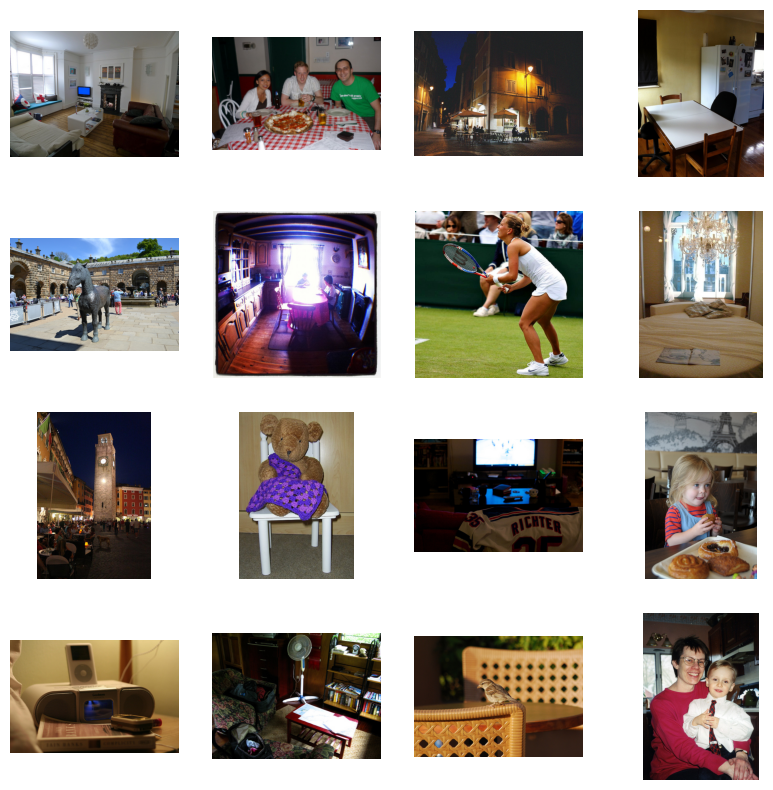

In [33]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

Kreiranje dataset klase.

In [34]:
class ImageDataset(Dataset):
    def __init__(self, paths, train=True):
        if train:
            self.transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.RandomCrop((224, 224)),
                transforms.RandomHorizontalFlip()
            ])
        else:
            self.transform = transforms.Compose([transforms.Resize((224, 224))])
        
        self.paths = paths
        self.train = train

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transform(img)
        img_lab = rgb2lab(np.array(img)).astype("float32")
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1.
        ab = img_lab[[1, 2], ...] / 128.
        return {"L": L, "ab": ab}

In [36]:
batch_size = 32

train_dataset = ImageDataset(train_paths)
val_dataset = ImageDataset(val_paths, train=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

## Generator

## Diskriminator